# OpenFold Colab

Runs a simplified version of [OpenFold](https://github.com/aqlaboratory/openfold) on a target sequence. Adapted from DeepMind's [official AlphaFold Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb).

**Differences to AlphaFold v2.0**

OpenFold is a trainable PyTorch reimplementation of AlphaFold 2. For the purposes of inference, it is practically identical to the original ("practically" because ensembling is excluded from OpenFold (recycling is enabled, however)).

In this notebook, OpenFold is run with your choice of our original OpenFold parameters or DeepMind's publicly released parameters for AlphaFold 2.

**Note**

Like DeepMind's official Colab, this notebook uses **no templates (homologous structures)** and a selected portion of the full [BFD database](https://bfd.mmseqs.com/).

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) DeepMind's [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This Colab supports inference with the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license), made available under the Creative Commons Attribution 4.0 International ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode)) license. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). See the full license statement below.

**More information**

You can find more information about how AlphaFold/OpenFold works in DeepMind's two Nature papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)

FAQ on how to interpret AlphaFold/OpenFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

In [1]:
#@markdown ### Enter the amino acid sequence to fold ⬇️
sequence = 'MSTLTSVSGFPRIGQNRELKKIIEGYWKGANDLAAVKATAAELRAKHWRLQQAAGIDLIASNDFSYYDQMLDTAILLNVIPQRYQRLAFDDQEDTLFAMA'  #@param {type:"string"}

#@markdown ### Configure the model ⬇️

weight_set = 'OpenFold' #@param ["OpenFold", "AlphaFold"]
relax_prediction = False #@param {type:"boolean"}

# Remove all whitespaces, tabs and end lines; upper-case
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
aatypes = set('ACDEFGHIKLMNPQRSTVWY')  # 20 standard aatypes
if not set(sequence).issubset(aatypes):
  raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. OpenFold only supports 20 standard amino acids as inputs.')

#@markdown After making your selections, execute this cell by pressing the
#@markdown *Play* button on the left.

In [2]:
#@title Install third-party software
#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.


#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with io.capture_output() as captured:
    %shell sudo apt install --quiet --yes hmmer

    # Install py3dmol.
    %shell pip install py3dmol

    %shell rm -rf /opt/conda
    %shell wget -q -P /tmp \
      https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
        && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
        && rm /tmp/Miniconda3-latest-Linux-x86_64.sh

    PATH=%env PATH
    %env PATH=/opt/conda/bin:{PATH}

    # Install the required versions of all dependencies.
    %shell conda install -y -q -c conda-forge -c bioconda \
      kalign2=2.04 \
      hhsuite=3.3.0 \
      python=3.7 \
      2>&1 1>/dev/null
    %shell pip install -q \
      ml-collections==0.1.0 \
      PyYAML==5.4.1 \
      biopython==1.79

    # Create a ramdisk to store a database chunk to make Jackhmmer run fast.
    %shell sudo mkdir -m 777 --parents /tmp/ramdisk
    %shell sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk

    %shell wget -q -P /content \
      https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt

    # Install AWS CLI
    %shell curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    %shell unzip -qq awscliv2.zip
    %shell sudo ./aws/install
    %shell rm awscliv2.zip
    %shell rm -rf ./aws
except subprocess.CalledProcessError as captured:
  print(captured)
  raise

In [3]:
#@title Install OpenFold
#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.

# Define constants
GIT_REPO='https://github.com/aqlaboratory/openfold'
ALPHAFOLD_PARAM_SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2022-01-19.tar'
OPENFOLD_PARAMS_DIR = './openfold/openfold/resources/openfold_params'
ALPHAFOLD_PARAMS_DIR = './openfold/openfold/resources/params'
ALPHAFOLD_PARAMS_PATH = os.path.join(
  ALPHAFOLD_PARAMS_DIR, os.path.basename(ALPHAFOLD_PARAM_SOURCE_URL)
)

try:
  with io.capture_output() as captured:
    # Run setup.py to install only Openfold.
    %shell rm -rf openfold
    %shell git clone "{GIT_REPO}" openfold 2>&1 1> /dev/null
    %shell mkdir -p /content/openfold/openfold/resources
    %shell cp -f /content/stereo_chemical_props.txt /content/openfold/openfold/resources
    %shell /usr/bin/python3 -m pip install -q ./openfold

    if(relax_prediction):
      %shell conda install -y -q -c conda-forge \
        openmm=7.5.1 \
        pdbfixer=1.7
      
      # Apply OpenMM patch.
      %shell pushd /opt/conda/lib/python3.7/site-packages/ && \
          patch -p0 < /content/openfold/lib/openmm.patch && \
          popd

    if(weight_set == 'AlphaFold'):
      %shell mkdir --parents "{ALPHAFOLD_PARAMS_DIR}"
      %shell wget -O {ALPHAFOLD_PARAMS_PATH} {ALPHAFOLD_PARAM_SOURCE_URL}
      %shell tar --extract --verbose --file="{ALPHAFOLD_PARAMS_PATH}" \
        --directory="{ALPHAFOLD_PARAMS_DIR}" --preserve-permissions
      %shell rm "{ALPHAFOLD_PARAMS_PATH}"
    elif(weight_set == 'OpenFold'):
      %shell mkdir --parents "{OPENFOLD_PARAMS_DIR}"
      %shell aws s3 cp \
        --no-sign-request \
        --region us-east-1 \
        s3://openfold/openfold_params "{OPENFOLD_PARAMS_DIR}" \
        --recursive
    else:
      raise ValueError("Invalid weight set")
except subprocess.CalledProcessError as captured:
  print(captured)
  raise

In [4]:
#@title Import Python packages
#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.

import unittest.mock
import sys

sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
sys.path.append('/opt/conda/lib/python3.7/site-packages')

# Allows us to skip installing these packages
unnecessary_modules = [
  "dllogger",
  "pytorch_lightning",
  "pytorch_lightning.utilities",
  "pytorch_lightning.callbacks.early_stopping",
  "pytorch_lightning.utilities.seed",
]
for unnecessary_module in unnecessary_modules:
  sys.modules[unnecessary_module] = unittest.mock.MagicMock()

import os

from urllib import request
from concurrent import futures
from google.colab import files
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import torch

# A filthy hack to avoid slow Linear layer initialization
import openfold.model.primitives

def __default_linear_init__(self, *args, **kwargs):
    return torch.nn.Linear.__init__(
      self, 
      *args[:2], 
      **{k:v for k,v in kwargs.items() if k == "bias"}
    )

openfold.model.primitives.Linear.__init__ = __default_linear_init__

from openfold import config
from openfold.data import feature_pipeline
from openfold.data import parsers
from openfold.data import data_pipeline
from openfold.data.tools import jackhmmer
from openfold.model import model
from openfold.np import protein
if(relax_prediction):
  from openfold.np.relax import relax
  from openfold.np.relax import utils
from openfold.utils.import_weights import import_jax_weights_
from openfold.utils.tensor_utils import tensor_tree_map

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

## Making a prediction

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab (see FAQ below).

  0%|          | 0/147 [elapsed: 00:00 remaining: ?]

7028 Sequences Found in uniref90
279 Sequences Found in smallbfd
396 Sequences Found in mgnify

7628 Sequences Found in Total



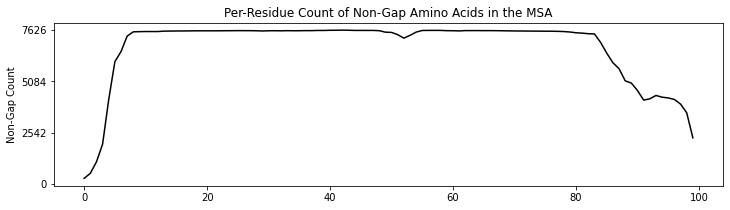

In [5]:
#@title Search against genetic databases

#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by OpenFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.

# --- Find the closest source ---
test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
ex = futures.ThreadPoolExecutor(3)
def fetch(source):
  request.urlretrieve(test_url_pattern.format(source))
  return source
fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
source = None
for f in futures.as_completed(fs):
  source = f.result()
  ex.shutdown()
  break

# --- Search against genetic databases ---
with open('target.fasta', 'wt') as f:
  f.write(f'>query\n{sequence}')

# Run the search against chunks of genetic databases (since the genetic
# databases don't fit in Colab ramdisk).

jackhmmer_binary_path = '/usr/bin/jackhmmer'
dbs = []

num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())
with tqdm.notebook.tqdm(total=total_jackhmmer_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
  def jackhmmer_chunk_callback(i):
    pbar.update(n=1)

  pbar.set_description('Searching uniref90')
  jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/uniref90_2021_03.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=135301051)
  dbs.append(('uniref90', jackhmmer_uniref90_runner.query('target.fasta')))

  pbar.set_description('Searching smallbfd')
  jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/bfd-first_non_consensus_sequences.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=65984053)
  dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query('target.fasta')))

  pbar.set_description('Searching mgnify')
  jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
      binary_path=jackhmmer_binary_path,
      database_path=f'https://storage.googleapis.com/alphafold-colab{source}/latest/mgy_clusters_2019_05.fasta',
      get_tblout=True,
      num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
      streaming_callback=jackhmmer_chunk_callback,
      z_value=304820129)
  dbs.append(('mgnify', jackhmmer_mgnify_runner.query('target.fasta')))


# --- Extract the MSAs and visualize ---
# Extract the MSAs from the Stockholm files.
# NB: deduplication happens later in data_pipeline.make_msa_features.

mgnify_max_hits = 501

msas = []
deletion_matrices = []
full_msa = []
for db_name, db_results in dbs:
  unsorted_results = []
  for i, result in enumerate(db_results):
    msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
    e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
    e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
    zipped_results = zip(msa, deletion_matrix, target_names, e_values)
    if i != 0:
      # Only take query from the first chunk
      zipped_results = [x for x in zipped_results if x[2] != 'query']
    unsorted_results.extend(zipped_results)
  sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
  db_msas, db_deletion_matrices, _, _ = zip(*sorted_by_evalue)
  if db_msas:
    if db_name == 'mgnify':
      db_msas = db_msas[:mgnify_max_hits]
      db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
    full_msa.extend(db_msas)
    msas.append(db_msas)
    deletion_matrices.append(db_deletion_matrices)
    msa_size = len(set(db_msas))
    print(f'{msa_size} Sequences Found in {db_name}')

deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
print(f'\n{total_msa_size} Sequences Found in Total\n')

aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

fig = plt.figure(figsize=(12, 3))
plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), color='black')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, num_alignments + 1, max(1, int(num_alignments / 3))))
plt.show()

  0%|          | 0/6 [elapsed: 00:00 remaining: ?]

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

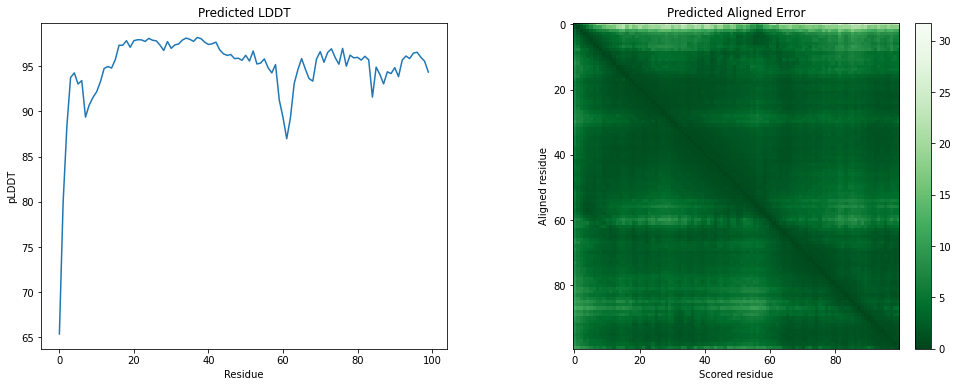

In [8]:
#@title Run OpenFold and download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# Color bands for visualizing plddt
PLDDT_BANDS = [
  (0, 50, '#FF7D45'),
  (50, 70, '#FFDB13'),
  (70, 90, '#65CBF3'),
  (90, 100, '#0053D6')
]

# --- Run the model ---
model_names = [ 
  'finetuning_3.pt', 
  'finetuning_4.pt', 
  'finetuning_5.pt', 
  'finetuning_ptm_2.pt',
  'finetuning_no_templ_ptm_1.pt'
]

def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': np.zeros((num_templates_, num_res_, 22), dtype=np.int64),
      'template_all_atom_positions': np.zeros((num_templates_, num_res_, 37, 3), dtype=np.float32),
      'template_all_atom_mask': np.zeros((num_templates_, num_res_, 37), dtype=np.float32),
      'template_domain_names': np.zeros((num_templates_,), dtype=np.float32),
      'template_sum_probs': np.zeros((num_templates_, 1), dtype=np.float32),
  }

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
pae_outputs = {}
unrelaxed_proteins = {}

with tqdm.notebook.tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
  for i, model_name in list(enumerate(model_names)):
    pbar.set_description(f'Running {model_name}')
    num_templates = 1 # dummy number --- is ignored
    num_res = len(sequence)
    
    feature_dict = {}
    feature_dict.update(data_pipeline.make_sequence_features(sequence, 'test', num_res))
    feature_dict.update(data_pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
    feature_dict.update(_placeholder_template_feats(num_templates, num_res))

    if(weight_set == "AlphaFold"):
      config_preset = f"model_{i}"
    else:
      if("_no_templ_" in model_name):
        config_preset = "model_3"
      else:
        config_preset = "model_1"
      if("_ptm_" in model_name):
        config_preset += "_ptm"

    cfg = config.model_config(config_preset)
    openfold_model = model.AlphaFold(cfg)
    openfold_model = openfold_model.eval()
    if(weight_set == "AlphaFold"):
      params_name = os.path.join(
        ALPHAFOLD_PARAMS_DIR, f"params_{config_preset}.npz"
      )
      import_jax_weights_(openfold_model, params_name, version=config_preset)
    elif(weight_set == "OpenFold"):
      params_name = os.path.join(
        OPENFOLD_PARAMS_DIR,
        model_name,
      )
      d = torch.load(params_name)
      openfold_model.load_state_dict(d)
    else:
      raise ValueError(f"Invalid weight set: {weight_set}")

    openfold_model = openfold_model.cuda()

    pipeline = feature_pipeline.FeaturePipeline(cfg.data)
    processed_feature_dict = pipeline.process_features(
      feature_dict, mode='predict'
    )

    processed_feature_dict = tensor_tree_map(
        lambda t: t.cuda(), processed_feature_dict
    )

    with torch.no_grad():
      prediction_result = openfold_model(processed_feature_dict)

    # Move the batch and output to np for further processing
    processed_feature_dict = tensor_tree_map(
      lambda t: np.array(t[..., -1].cpu()), processed_feature_dict
    )
    prediction_result = tensor_tree_map(
      lambda t: np.array(t.cpu()), prediction_result
    )

    mean_plddt = prediction_result['plddt'].mean()

    if 'predicted_aligned_error' in prediction_result:
      pae_outputs[model_name] = (
          prediction_result['predicted_aligned_error'],
          prediction_result['max_predicted_aligned_error']
      )
    else:
      # Get the pLDDT confidence metrics. Do not put pTM models here as they
      # should never get selected.
      plddts[model_name] = prediction_result['plddt']

    # Set the b-factors to the per-residue plddt.
    final_atom_mask = prediction_result['final_atom_mask']
    b_factors = prediction_result['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(
      processed_feature_dict, prediction_result, b_factors=b_factors
    )
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del openfold_model
    del processed_feature_dict
    del prediction_result
    pbar.update(n=1)

  # Find the best model according to the mean pLDDT.
  best_model_name = max(plddts.keys(), key=lambda x: plddts[x].mean())
  best_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])

  # --- AMBER relax the best model ---
  if(relax_prediction):
    pbar.set_description(f'AMBER relaxation')
    amber_relaxer = relax.AmberRelaxation(
        max_iterations=0,
        tolerance=2.39,
        stiffness=10.0,
        exclude_residues=[],
        max_outer_iterations=20,
        use_gpu=False,
    )
    relaxed_pdb, _, _ = amber_relaxer.process(
        prot=unrelaxed_proteins[best_model_name]
    )

    # Write out the prediction
    pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
    with open(pred_output_path, 'w') as f:
      f.write(relaxed_pdb)

    best_pdb = relaxed_pdb

  pbar.update(n=1)  # Finished AMBER relax.

# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
#to_visualize_pdb = utils.overwrite_b_factors(best_pdb, banded_b_factors)
to_visualize_pdb = best_pdb

# --- Visualise the prediction & confidence ---
show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = [
            'Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {
    'colorscheme': {
        'prop': 'b',
        'map': color_map}
        }}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = list(pae_outputs.values())[0]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save pLDDT and predicted aligned error (if it exists)
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB
  rounded_errors = np.round(pae.astype(np.float64), decimals=1)
  indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
  indices_1 = indices[0].flatten().tolist()
  indices_2 = indices[1].flatten().tolist()
  pae_data = json.dumps([{
      'residue1': indices_1,
      'residue2': indices_2,
      'distance': rounded_errors.flatten().tolist(),
      'max_predicted_aligned_error': max_pae.item()
  }],
                        indent=None,
                        separators=(',', ':'))
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)


# --- Download the predictions ---
!zip -q -r {output_dir}.zip {output_dir}
files.download(f'{output_dir}.zip')

In [9]:
to_visualize_pdb

'PARENT N/A\nATOM      1  N   MET A   1     -13.467  -2.872  34.095  1.00 65.39           N  \nATOM      2  CA  MET A   1     -13.251  -3.738  32.940  1.00 65.39           C  \nATOM      3  C   MET A   1     -12.631  -2.960  31.784  1.00 65.39           C  \nATOM      4  CB  MET A   1     -14.566  -4.379  32.494  1.00 65.39           C  \nATOM      5  O   MET A   1     -13.103  -1.875  31.437  1.00 65.39           O  \nATOM      6  CG  MET A   1     -14.815  -5.752  33.096  1.00 65.39           C  \nATOM      7  SD  MET A   1     -16.214  -6.628  32.295  1.00 65.39           S  \nATOM      8  CE  MET A   1     -17.042  -7.313  33.757  1.00 65.39           C  \nATOM      9  N   SER A   2     -11.357  -3.075  31.582  1.00 79.92           N  \nATOM     10  CA  SER A   2     -10.706  -2.354  30.493  1.00 79.92           C  \nATOM     11  C   SER A   2     -11.341  -2.692  29.148  1.00 79.92           C  \nATOM     12  CB  SER A   2      -9.211  -2.675  30.455  1.00 79.92           C  \nATO

### Interpreting the prediction

Please see the [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2) and the [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1), as well as [DeepMind's FAQ](https://alphafold.ebi.ac.uk/faq) on how to interpret AlphaFold/OpenFold predictions.

## FAQ & Troubleshooting


*   How do I get a predicted protein structure for my protein?
    *   Click on the _Connect_ button on the top right to get started.
    *   Paste the amino acid sequence of your protein (without any headers) into the “Enter the amino acid sequence to fold”.
    *   Run all cells in the Colab, either by running them individually (with the play button on the left side) or via _Runtime_ > _Run all._
    *   The predicted protein structure will be downloaded once all cells have been executed. Note: This can take minutes to hours - see below.
*   How long will this take?
    *   Downloading the OpenFold source code can take up to a few minutes.
    *   Downloading and installing the third-party software can take up to a few minutes.
    *   The search against genetic databases can take minutes to hours.
    *   Running OpenFold and generating the prediction can take minutes to hours, depending on the length of your protein and on which GPU-type Colab has assigned you.
*   My Colab no longer seems to be doing anything, what should I do?
    *   Some steps may take minutes to hours to complete.
    *   Sometimes, running the "installation" cells more than once can corrupt the OpenFold installation.
    *   If nothing happens or if you receive an error message, try restarting your Colab runtime via _Runtime_ > _Restart runtime_.
    *   If this doesn’t help, reset your Colab runtime via _Runtime_ > _Factory reset runtime_.
*   How does what's run in this notebook compare to the full versions of Alphafold/Openfold?
    *   This Colab version of OpenFold searches a selected portion of the BFD dataset and currently doesn’t use templates, so its accuracy is reduced in comparison to the full version, which is analogous to what's described in the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2) and [Github repo](https://github.com/deepmind/alphafold/). The full version of OpenFold can be run from our own [GitHub repo](https://github.com/aqlaboratory/openfold).
*   What is a Colab?
    *   See the [Colab FAQ](https://research.google.com/colaboratory/faq.html).
*   I received a warning “Notebook requires high RAM”, what do I do?
    *   The resources allocated to your Colab vary. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   You can execute the Colab nonetheless.
*   I received an error “Colab CPU runtime not supported” or “No GPU/TPU found”, what do I do?
    *   Colab CPU runtime is not supported. Try changing your runtime via _Runtime_ > _Change runtime type_ > _Hardware accelerator_ > _GPU_.
    *   The type of GPU allocated to your Colab varies. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   If you receive “Cannot connect to GPU backend”, you can try again later to see if Colab allocates you a GPU.
    *   [Colab Pro](https://colab.research.google.com/signup) offers priority access to GPUs. 
*   Does this tool install anything on my computer?
    *   No, everything happens in the cloud on Google Colab.
    *   At the end of the Colab execution a zip-archive with the obtained prediction will be automatically downloaded to your computer.
*   How should I share feedback and bug reports?
    *   Please share any feedback and bug reports as an [issue](https://github.com/aqlaboratory/openfold/issues) on Github.


# License and Disclaimer

This Colab notebook and other information provided is for theoretical modelling only, caution should be exercised in its use. It is provided ‘as-is’ without any warranty of any kind, whether expressed or implied. Information is not intended to be a substitute for professional medical advice, diagnosis, or treatment, and does not constitute medical or other professional advice.

## AlphaFold/OpenFold Code License

Copyright 2021 AlQuraishi Laboratory

Copyright 2021 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Model Parameters License

DeepMind's AlphaFold parameters are made available under the terms of the Creative Commons Attribution 4.0 International (CC BY 4.0) license. You can find details at: https://creativecommons.org/licenses/by/4.0/legalcode


## Third-party software

Use of the third-party software, libraries or code referred to in this notebook may be governed by separate terms and conditions or license provisions. Your use of the third-party software, libraries or code is subject to any such terms and you should check that you can comply with any applicable restrictions or terms and conditions before use.


## Mirrored Databases

The following databases have been mirrored by DeepMind, and are available with reference to the following:
* UniRef90: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* MGnify: v2019\_05 (unmodified), by Mitchell AL et al., available free of all copyright restrictions and made fully and freely available for both non-commercial and commercial use under [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).
* BFD: (modified), by Steinegger M. and Söding J., modified by DeepMind, available under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by/4.0/). See the Methods section of the [AlphaFold proteome paper](https://www.nature.com/articles/s41586-021-03828-1) for details.